# Timeseries Foundation Model Experiment

## Original Paper: "Deep spatio-temporal residual networks for citywide crowd flows prediction"

https://arxiv.org/pdf/1610.00081

The goal is to predict one step ahead

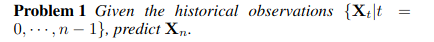

### Datasets

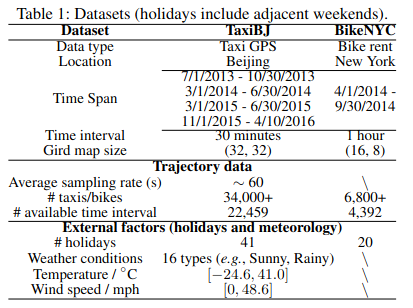

* TaxiBJ: the last four weeks as the testing data, and all data before that as training data.
* BikeNYC: the last 10 days are chosen as testing data, and the others as training data.

### Results

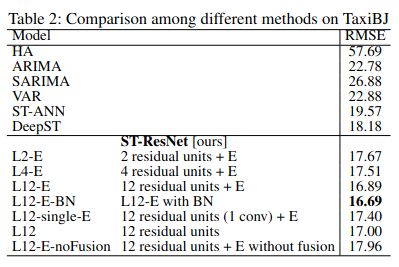
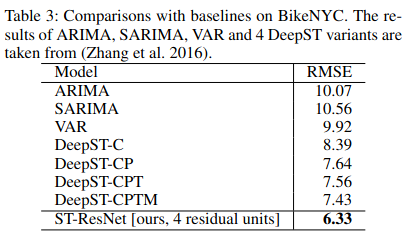

## Experiment

In [10]:
# [dataset]
data_files = ["./datasets/BikeNYC/NYC14_M16x8_T60_NewEnd.h5"]
holiday_file = ""
meteorol_file = ""
T = 24  # time step of one hour
len_closeness = 3
len_period = 1
len_trend = 1
period_interval = 1
trend_interval = 7
len_test = 672
use_meta = True

# [model]
nb_flow = 2
map_height = 8
map_width = 16
nb_residual_unit = 4

# [learning]
epochs = 50
batch_size = 32
learning_rate = 0.0002


In [ ]:
import tables
import numpy as np

In [ ]:
def remove_incomplete_days(dat: tables.file.File, T: int) -> tuple[np.ndarray, np.ndarray]:
    # 20140425 has 24 timestamps, which does not appear in `incomplete_days` in the original implementation.
    # So I reimplemented it in a different way.
    data = dat.root.data.read()
    timestamps = dat.root.date.read().astype(str)

    dates, values = np.vstack(
        np.frompyfunc(lambda x: (x[:8], x[8:]), 1, 2)(timestamps)
    )
    # label encoding
    uniq_dates, labels = np.unique(dates, return_inverse=True)
    # groupby("labels")["values"].sum() != sum(range(1, 49))
    incomplete_days = uniq_dates[
        np.where(np.bincount(labels, values.astype(int)) != sum(range(1, (T + 1))))[
            0
        ]
    ]
    del_idx = np.where(np.isin(dates, incomplete_days))[0]
    new_data = np.delete(data, del_idx, axis=0)
    new_timestamps = np.delete(timestamps, del_idx)
    return new_data, new_timestamps

In [7]:
dat=tables.open_file(data_files[0],mode="r")
data=dat.root.data.read()
data

array([[[[ 0.,  0.,  1., ...,  0.,  0.,  0.],
         [ 0.,  1.,  1., ...,  1.,  0.,  0.],
         [ 0.,  0.,  2., ...,  2.,  2.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  3.,  1.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  1.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  1.,  0.,  0.],
         [ 0.,  0.,  0., ...,  1.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  1.,  0.],
         [ 0.,  0.,  0., ...,  2.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]],


       [[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  1.,  2.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  1.,  0.,  1.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  1., ..., 

In [12]:
datasets = remove_incomplete_days(dat,T)
datasets

(array([[[[ 0.,  0.,  1., ...,  0.,  0.,  0.],
          [ 0.,  1.,  1., ...,  1.,  0.,  0.],
          [ 0.,  0.,  2., ...,  2.,  2.,  0.],
          ...,
          [ 0.,  0.,  0., ...,  3.,  1.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  1.]],
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  1.,  0.,  0.],
          [ 0.,  0.,  0., ...,  1.,  0.,  0.],
          ...,
          [ 0.,  0.,  0., ...,  0.,  1.,  0.],
          [ 0.,  0.,  0., ...,  2.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.]]],
 
 
        [[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0., ...,  0.,  1.,  2.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  1.,  0.,  1.]],
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
   

In [26]:
datasets[1]

array(['2014040101', '2014040102', '2014040103', ..., '2014093022',
       '2014093023', '2014093024'], shape=(4392,), dtype='<U10')

In [74]:
def extract_timeseries(data: np.ndarray, row: int, col: int, channel: int = 0) -> np.ndarray:
    """
    Extracts the time series of a specific grid location from a 4D numpy array.
    
    Parameters:
        data (np.ndarray): A 4D numpy array with shape (time_steps, channels, height, width)
        row (int): The row index of the desired grid location
        col (int): The column index of the desired grid location
        channel (int): The channel index to extract from (default: 0)
        
    Returns:
        np.ndarray: A 1D array representing the time series at the specified location
    """
    if data.ndim != 4:
        raise ValueError("Input data must be a 4D numpy array (time_steps, channels, height, width)")
    
    if not (0 <= row < data.shape[2]) or not (0 <= col < data.shape[3]):
        raise ValueError("Row or column index out of bounds")
    
    if not (0 <= channel < data.shape[1]):
        raise ValueError("Channel index out of bounds")
    
    return data[:, channel, row, col]

# Example usage:
# Assuming `grid_data` is the provided numpy array
grid_data = datasets[0]

ROW=0
COL=0

# Extract time series from row 5, column 3 in channel 0
time_series = extract_timeseries(grid_data, row=ROW, col=COL, channel=0)

print(time_series)


[0. 0. 0. ... 0. 0. 0.]


In [75]:
len(time_series)

4392

In [76]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


In [77]:

def adjust_timestamps(timestamps):
    """
    Adjusts the given timestamps by subtracting 1 hour from each entry.
    
    Parameters:
        timestamps (numpy array): Array of timestamps in 'YYYYMMDDHH' format.
        
    Returns:
        numpy array: Adjusted timestamps.
    """
    adjusted = []
    for ts in timestamps:
        # Fix invalid '24' hour case
        if ts[-2:] == '24':
            ts = (datetime.strptime(ts[:8], "%Y%m%d") + timedelta(days=1)).strftime("%Y%m%d") + "00"
        dt = datetime.strptime(ts, "%Y%m%d%H") - timedelta(hours=1)
        adjusted.append(dt.strftime("%Y%m%d%H"))
    
    return np.array(adjusted, dtype='<U10')

# Example usage
timestamps = datasets[1]
timestamps = adjust_timestamps(timestamps)
timestamps

array(['2014040100', '2014040101', '2014040102', ..., '2014093021',
       '2014093022', '2014093023'], shape=(4392,), dtype='<U10')

In [78]:
def format_timestamp(timestamp: str) -> str:
    """
    Converts timestamp from 'YYYYMMDDHH' to 'YYYY-MM-DD HH:00'.
    
    Parameters:
        timestamp (str): A string representing the timestamp in 'YYYYMMDDHH' format.
        
    Returns:
        str: Formatted timestamp as 'YYYY-MM-DD HH:00'.
    """
    dt = datetime.strptime(timestamp, "%Y%m%d%H")
    return dt.strftime("%Y-%m-%d %H:00")

def create_dataframe(timeseries: np.ndarray, timestamps: np.ndarray) -> pd.DataFrame:
    """
    Creates a pandas DataFrame from the extracted time series and timestamps.
    
    Parameters:
        timeseries (np.ndarray): A 1D numpy array representing the time series
        timestamps (np.ndarray): A 1D numpy array of timestamps corresponding to the time series
        
    Returns:
        pd.DataFrame: A DataFrame containing timestamps and values
    """
    if timeseries.shape[0] != timestamps.shape[0]:
        raise ValueError("Time series and timestamps must have the same length")

    formatted_timestamps = [format_timestamp(ts) for ts in timestamps]

    df = pd.DataFrame({
        'timestamp': formatted_timestamps,
        'value': timeseries
    })
    return df


df = create_dataframe(time_series, timestamps)
print(df)

             timestamp  value
0     2014-04-01 00:00    0.0
1     2014-04-01 01:00    0.0
2     2014-04-01 02:00    0.0
3     2014-04-01 03:00    0.0
4     2014-04-01 04:00    0.0
...                ...    ...
4387  2014-09-30 19:00    0.0
4388  2014-09-30 20:00    0.0
4389  2014-09-30 21:00    0.0
4390  2014-09-30 22:00    0.0
4391  2014-09-30 23:00    0.0

[4392 rows x 2 columns]


Get the last 10 days for validation, like in the paper (+5 as input):

In [79]:
df = df[df['timestamp']>='2014-09-16 00:00']

### TimeGPT

In [80]:
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    api_key = "xxx"
)

In [82]:
nixtla_client.validate_api_key()

INFO:nixtla.nixtla_client:Happy Forecasting! :)


True

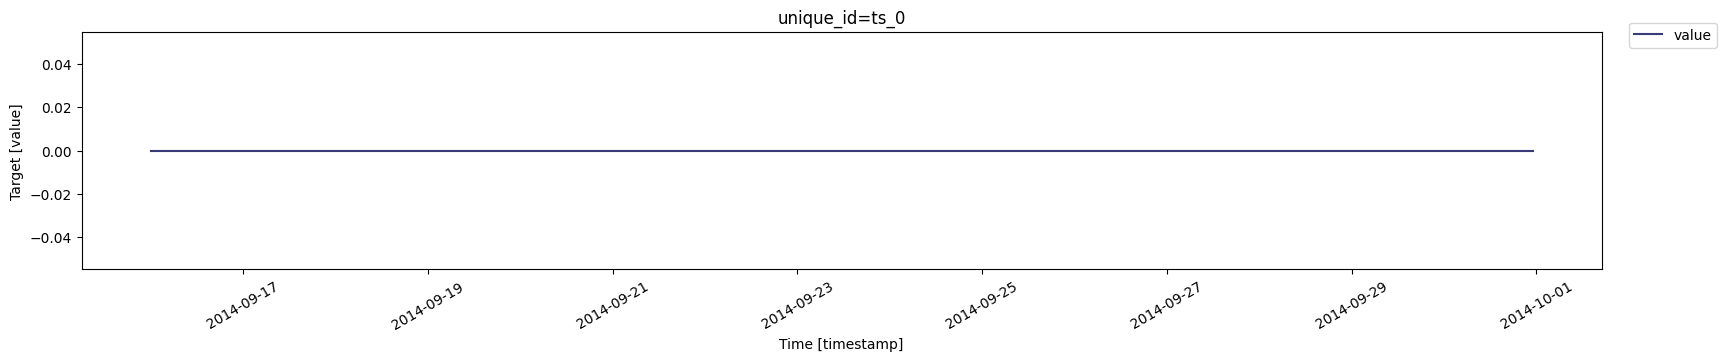

In [83]:
nixtla_client.plot(df, time_col='timestamp', target_col='value')

#### Simple forecast

In [84]:
timegpt_fcst_df = nixtla_client.forecast(df=df, h=1, freq='h', time_col='timestamp', target_col='value')
timegpt_fcst_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,timestamp,TimeGPT
0,2014-10-01,0.003318


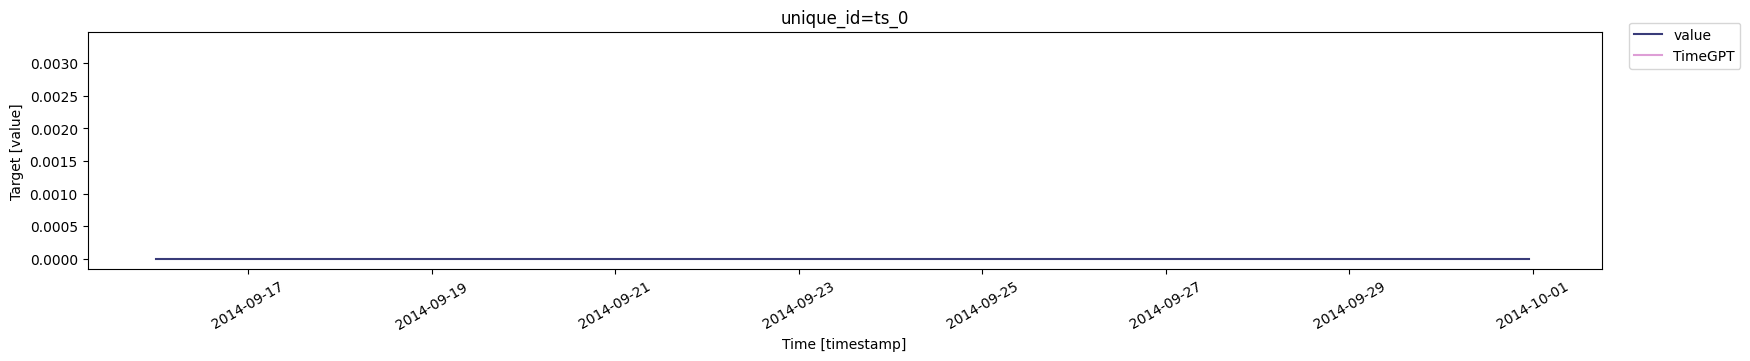

In [85]:
nixtla_client.plot(df, timegpt_fcst_df, time_col='timestamp', target_col='value')

#### Historical forecast

In [86]:
timegpt_fcst_with_history_df = nixtla_client.forecast(
    df=df, h=1, time_col='timestamp', target_col='value', freq='h',
    add_history=True,
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...


In [87]:
timegpt_fcst_with_history_df.to_csv(f'predictions/timegpt/fcst_{ROW}_{COL}.csv')

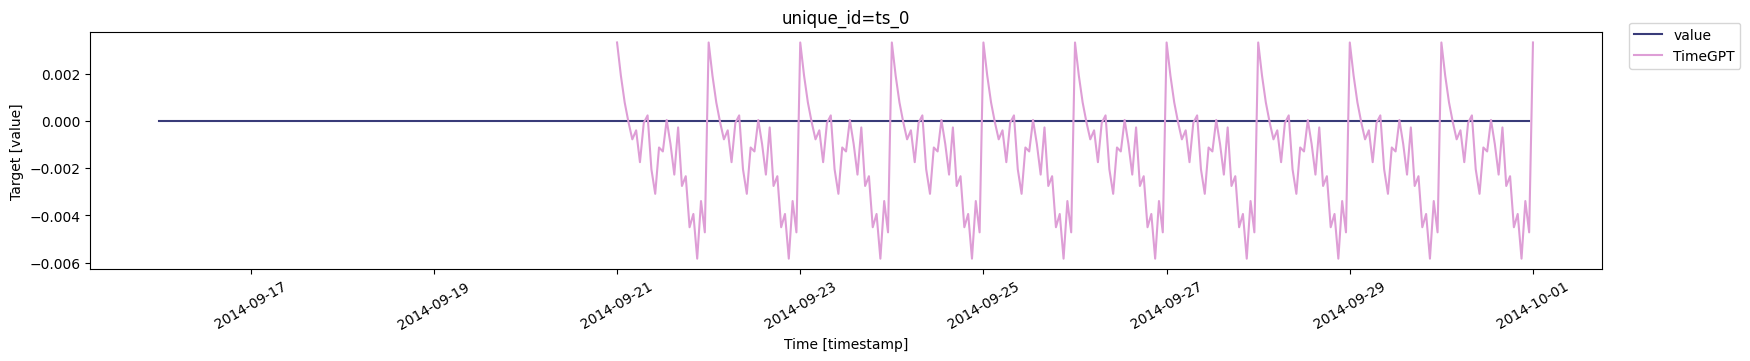

In [88]:
nixtla_client.plot(df, timegpt_fcst_with_history_df, time_col='timestamp', target_col='value')


In [89]:
def compute_rmse(original_df, forecast_df):
    # Convert timestamp to datetime
    original_df['timestamp'] = pd.to_datetime(original_df['timestamp'])
    forecast_df['timestamp'] = pd.to_datetime(forecast_df['timestamp'])

    # Merge the DataFrames based on the timestamp
    merged_df = pd.merge(original_df, forecast_df, on='timestamp', how='inner')

    # Calculate the squared differences
    merged_df['squared_diff'] = (merged_df['value'] - merged_df['TimeGPT'])**2

    # Calculate RMSE
    rmse = np.sqrt(merged_df['squared_diff'].mean())
    return rmse

rmse = compute_rmse(df,timegpt_fcst_with_history_df)
print(f"RMSE: {rmse}")


RMSE: 0.002570502930800306


#### Run forecasts for all grid cells and store results

In [94]:
import os.path

def prediction_exists(row, col):
    return os.path.isfile(f'predictions/timegpt/fcst_{row}_{col}.csv')

prediction_exists(2,1)

False

In [97]:
def load_prediction(row,col):
    timegpt_fcst_with_history_df = pd.read_csv(f'predictions/timegpt/fcst_{row}_{col}.csv')
    return timegpt_fcst_with_history_df

load_prediction(1,3)

,timestamp,TimeGPT
0,2014-09-21 00:00:00,16.648037
1,2014-09-21 01:00:00,10.752392
2,2014-09-21 02:00:00,6.054309
3,2014-09-21 03:00:00,2.488530
4,2014-09-21 04:00:00,1.055259
...,...,...
236,2014-09-30 20:00:00,28.864220
237,2014-09-30 21:00:00,26.119790
238,2014-09-30 22:00:00,21.338356
239,2014-09-30 23:00:00,13.381630


In [105]:
def compute_cell_rmse(row, col):
    time_series = extract_timeseries(grid_data, row=row, col=col, channel=0)
    timestamps = datasets[1]
    timestamps = adjust_timestamps(timestamps)
    df = create_dataframe(time_series, timestamps)
    df = df[df['timestamp']>='2014-09-16 00:00']

    if prediction_exists(row, col):
        print('Loading predictions ...')
        timegpt_fcst_with_history_df = load_prediction(row, col)
    else:
        print('Computing predicitons ...')
        timegpt_fcst_with_history_df = nixtla_client.forecast(
            df=df, h=1, time_col='timestamp', target_col='value', freq='h',
            add_history=True,
        )
        timegpt_fcst_with_history_df.to_csv(f'predictions/timegpt/fcst_{row}_{col}.csv', index=False)
    rmse = compute_rmse(df, timegpt_fcst_with_history_df)
    print(f"[{row},{col}] RMSE:{rmse}")
    return rmse

rmses =  []

for row in range(0,16):
    for col in range(0,8):
        rmses.append(compute_cell_rmse(row,col))

print(rmses)



Loading predictions ...
[0,0] RMSE:0.002570502930800306
Loading predictions ...
[0,1] RMSE:0.002570502930800306
Loading predictions ...
[0,2] RMSE:3.5633947837540783
Loading predictions ...
[0,3] RMSE:10.037934923310697
Loading predictions ...
[0,4] RMSE:15.239814706642761
Loading predictions ...
[0,5] RMSE:0.002570502930800306


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Loading predictions ...
[0,6] RMSE:0.002570502930800306
Loading predictions ...
[0,7] RMSE:0.002570502930800306
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[1,0] RMSE:0.002570502930800306
Loading predictions ...
[1,1] RMSE:6.072188987583208
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[1,2] RMSE:6.10467960056596
Loading predictions ...
[1,3] RMSE:10.603164877491775
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[1,4] RMSE:13.917665751860108
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[1,5] RMSE:11.204286010693234
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[1,6] RMSE:2.810509161338358
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[1,7] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[2,0] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[2,1] RMSE:3.094132360384688
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[2,2] RMSE:8.124441799259046
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[2,3] RMSE:14.124176681319927
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[2,4] RMSE:9.87947194144156
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[2,5] RMSE:19.116945715244864
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[2,6] RMSE:4.0930457339758926
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[2,7] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[3,0] RMSE:0.002570502930800306
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[3,1] RMSE:9.823857990415844
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[3,2] RMSE:13.609803980126207
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[3,3] RMSE:19.39126985581633
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[3,4] RMSE:24.82940198763119
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[3,5] RMSE:8.01946406849938
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[3,6] RMSE:0.002570502930800306
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[3,7] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[4,0] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[4,1] RMSE:15.353709343653744
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[4,2] RMSE:13.703235791015969
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[4,3] RMSE:13.525093211179996
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[4,4] RMSE:9.825678636444476
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[4,5] RMSE:7.809890565314297
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[4,6] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[4,7] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[5,0] RMSE:0.002570502930800306
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[5,1] RMSE:18.817138848097564
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[5,2] RMSE:17.183880967133586
Loading predictions ...
[5,3] RMSE:19.97543575145462
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[5,4] RMSE:14.245502307836027
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[5,5] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[5,6] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[5,7] RMSE:0.002570502930800306
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[6,0] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[6,1] RMSE:16.935044642220817
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[6,2] RMSE:18.79578174157705
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[6,3] RMSE:20.080684570699418
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[6,4] RMSE:11.641629805276798
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[6,5] RMSE:0.002570502930800306
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[6,6] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[6,7] RMSE:0.002570502930800306
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[7,0] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[7,1] RMSE:13.642025157738148
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[7,2] RMSE:17.016431550912763
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[7,3] RMSE:21.37184891958808
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[7,4] RMSE:8.20325748668239
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[7,5] RMSE:0.002570502930800306
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[7,6] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[7,7] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[8,0] RMSE:6.403986488399714
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[8,1] RMSE:11.873086183839364
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[8,2] RMSE:12.35191115935829
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[8,3] RMSE:15.479802706277466
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[8,4] RMSE:8.601080918207966
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[8,5] RMSE:1.547153580097292
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[8,6] RMSE:0.002570502930800306
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[8,7] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[9,0] RMSE:24.094423827936296
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[9,1] RMSE:8.012939328699487
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[9,2] RMSE:8.77825577110615
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[9,3] RMSE:7.686780244079536
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[9,4] RMSE:5.639365513049377
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[9,5] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[9,6] RMSE:4.854884546519325
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[9,7] RMSE:0.002570502930800306
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[10,0] RMSE:14.313091700592
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[10,1] RMSE:9.821399516794514
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[10,2] RMSE:6.817657614659597
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[10,3] RMSE:5.287142657538004
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[10,4] RMSE:3.880122899223147
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[10,5] RMSE:0.002570502930800306
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[10,6] RMSE:5.188028338714668
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[10,7] RMSE:2.1259317656706505
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[11,0] RMSE:13.488011454485571
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[11,1] RMSE:12.72174381434626
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[11,2] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[11,3] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[11,4] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[11,5] RMSE:1.6790453164840837
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[11,6] RMSE:0.9429252848834933
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[11,7] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[12,0] RMSE:7.752473567223986
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[12,1] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[12,2] RMSE:5.74673617862669
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[12,3] RMSE:9.750837264686353
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[12,4] RMSE:2.5531225667590034
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[12,5] RMSE:1.8957608947336775
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[12,6] RMSE:0.002570502930800306
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[12,7] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[13,0] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[13,1] RMSE:0.002570502930800306
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[13,2] RMSE:2.9458867986620376
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[13,3] RMSE:7.710715412667907
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[13,4] RMSE:1.6876675342706142
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[13,5] RMSE:3.9700305727035357
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[13,6] RMSE:1.8811816927461884
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[13,7] RMSE:1.4560359282046909
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[14,0] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[14,1] RMSE:0.002570502930800306
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[14,2] RMSE:3.0911829947417
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[14,3] RMSE:4.0605317926657
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[14,4] RMSE:4.7903847224501765
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[14,5] RMSE:3.0232607390711816
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[14,6] RMSE:2.015987717342668
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[14,7] RMSE:0.9634530333874449
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[15,0] RMSE:0.002570502930800306
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[15,1] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[15,2] RMSE:0.0025654494710700606
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[15,3] RMSE:0.002570502930800306
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[15,4] RMSE:4.263672605310704
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[15,5] RMSE:1.470171475186865
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[15,6] RMSE:2.2082179371533774
Computing predicitons ...


INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...


[15,7] RMSE:2.0426881318865613
[np.float64(0.002570502930800306), np.float64(0.002570502930800306), np.float64(3.5633947837540783), np.float64(10.037934923310697), np.float64(15.239814706642761), np.float64(0.002570502930800306), np.float64(0.002570502930800306), np.float64(0.002570502930800306), np.float64(0.002570502930800306), np.float64(6.072188987583208), np.float64(6.10467960056596), np.float64(10.603164877491775), np.float64(13.917665751860108), np.float64(11.204286010693234), np.float64(2.810509161338358), np.float64(0.0025654494710700606), np.float64(0.0025654494710700606), np.float64(3.094132360384688), np.float64(8.124441799259046), np.float64(14.124176681319927), np.float64(9.87947194144156), np.float64(19.116945715244864), np.float64(4.0930457339758926), np.float64(0.0025654494710700606), np.float64(0.002570502930800306), np.float64(9.823857990415844), np.float64(13.609803980126207), np.float64(19.39126985581633), np.float64(24.82940198763119), np.float64(8.01946406849938)

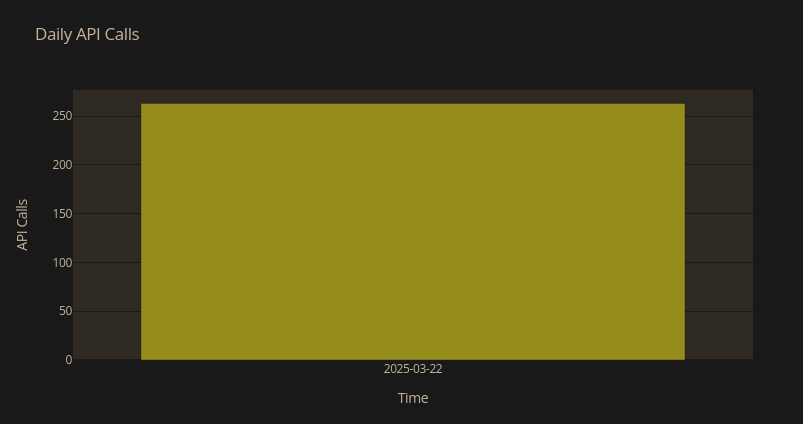

In [109]:
np.mean(rmses)

np.float64(5.7716825988548335)

Better than ST-ResNet? 

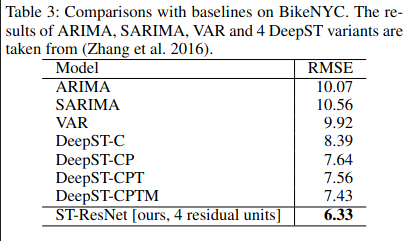